# Classification tasks that converts SMILES strings to ECFP4 fingerprint as feature vector

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import deepchem

from molecule_gym.core.classifiers import classify_binary_data
from molecule_gym.core.visualizations import plot_explained_variance
from molecule_gym.config import RESULTS_DIR

2023-05-31 20:23:52.836869: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-31 20:23:52.838299: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 20:23:52.863784: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 20:23:52.864720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 20:23:53.318971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Run Benchmark from deepchem

In [2]:
from deepchem.molnet.run_benchmark import run_benchmark

In [3]:
run_benchmark(datasets=['bbbp'], model='rf', out_path=RESULTS_DIR)

-------------------------------------
Benchmark on dataset: bbbp
-------------------------------------


## Data exploration

In [4]:
task, datasets, transformers = deepchem.molnet.load_bbbp()

In [5]:
train, test, validate = datasets

In [6]:
type(train)

deepchem.data.datasets.DiskDataset

In [7]:
train.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
print('Checking for class imbalance in datasets:')

u, c = np.unique(train.y, return_counts=True)
print(f"\nTraining set: {int(u[0])}: {c[0]}, {int(u[1])}: {c[1]}")

u, c = np.unique(test.y, return_counts=True)
print(f"\nTest set: {int(u[0])}: {c[0]}, {int(u[1])}: {c[1]}")

u, c = np.unique(validate.y, return_counts=True)
print(f"\nValidation set: {int(u[0])}: {c[0]}, {int(u[1])}: {c[1]}")

Checking for class imbalance in datasets:

Training set: 0: 290, 1: 1341

Test set: 0: 92, 1: 112

Validation set: 0: 97, 1: 107


### Collating datasets into single one

In [9]:
X = np.vstack([train.X, test.X, validate.X])

In [10]:
X.shape

(2039, 1024)

In [11]:
y = np.squeeze(np.concatenate((train.y, test.y, validate.y)))

In [12]:
y.shape

(2039,)

## Classification Using support vector classifier on ECFP fingerprint

### Unbalanced data

Training target statistics: Counter({1.0: 1084, 0.0: 343})
Testing target statistics: Counter({1.0: 476, 0.0: 136})
Using SVC classifier

Model performance on training data:
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.86       343
         1.0       0.93      0.99      0.96      1084

    accuracy                           0.94      1427
   macro avg       0.95      0.89      0.91      1427
weighted avg       0.94      0.94      0.94      1427


Model performance on test data:
              precision    recall  f1-score   support

         0.0       0.88      0.63      0.74       136
         1.0       0.90      0.97      0.94       476

    accuracy                           0.90       612
   macro avg       0.89      0.80      0.84       612
weighted avg       0.90      0.90      0.89       612



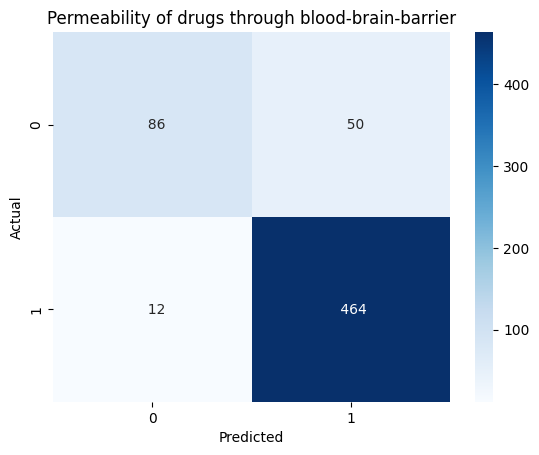

In [13]:
classify_binary_data(X, y)

### Oversampling the smallest class

Training target statistics: Counter({1.0: 1095, 0.0: 1095})
Testing target statistics: Counter({1.0: 465, 0.0: 465})
Using SVC classifier

Model performance on training data:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1095
         1.0       0.99      0.98      0.98      1095

    accuracy                           0.98      2190
   macro avg       0.98      0.98      0.98      2190
weighted avg       0.98      0.98      0.98      2190


Model performance on test data:
              precision    recall  f1-score   support

         0.0       0.92      0.70      0.79       465
         1.0       0.76      0.94      0.84       465

    accuracy                           0.82       930
   macro avg       0.84      0.82      0.81       930
weighted avg       0.84      0.82      0.81       930



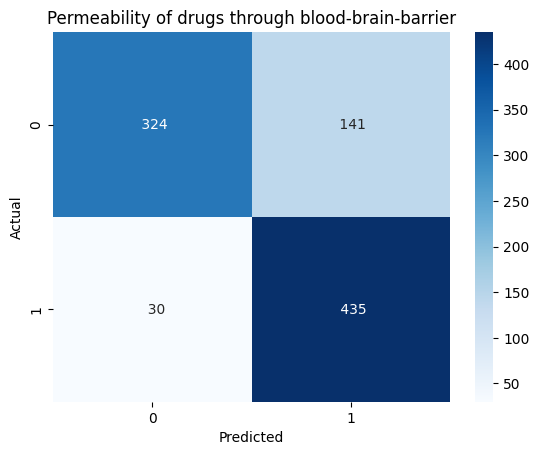

In [14]:
classify_binary_data(X, y, sampling='oversample')

### Undersampling the largest class

Training target statistics: Counter({0.0: 344, 1.0: 344})
Testing target statistics: Counter({0.0: 135, 1.0: 135})
Using SVC classifier

Model performance on training data:
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95       344
         1.0       0.92      0.99      0.95       344

    accuracy                           0.95       688
   macro avg       0.95      0.95      0.95       688
weighted avg       0.95      0.95      0.95       688


Model performance on test data:
              precision    recall  f1-score   support

         0.0       0.88      0.81      0.85       135
         1.0       0.83      0.89      0.86       135

    accuracy                           0.85       270
   macro avg       0.85      0.85      0.85       270
weighted avg       0.85      0.85      0.85       270



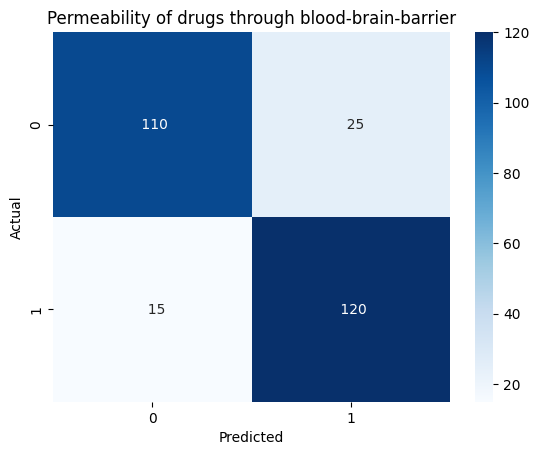

In [15]:
classify_binary_data(X, y, sampling='undersample')

## Pycaret pipeline for classification

In [16]:
from pycaret.classification import *

In [17]:
# Pycaret needs pandas datafrom as input
data_df = pd.DataFrame(X)
data_df['labels'] = y

In [18]:
exp_clf101 = setup(data=data_df, target='labels',
                   fold_strategy='kfold', fold_shuffle=True,
                   fix_imbalance=True, fix_imbalance_method='RandomUnderSampler',
                   normalize=False, normalize_method='robust',
                   remove_multicollinearity=False, multicollinearity_threshold=0.9,
                   experiment_name='bbbp_classifier_ECFP',
                   memory=RESULTS_DIR, profile=True,
                   session_id=69763)

,Description,Value
0,Session id,69763
1,Target,labels
2,Target type,Binary
3,Original data shape,"(2039, 1025)"
4,Transformed data shape,"(1282, 1025)"
5,Transformed train set shape,"(670, 1025)"
6,Transformed test set shape,"(612, 1025)"
7,Numeric features,1024
8,Preprocess,True
9,Imputation type,simple


Loading profile... Please Wait!
Profiler Failed. No output to show, continue with modeling.


In [19]:
top_n = compare_models(sort='F1', n_select=2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8662,0.8984,0.8885,0.9341,0.9102,0.6435,0.6490,0.1170
knn,K Neighbors Classifier,0.8542,0.8359,0.9342,0.8825,0.9071,0.5617,0.5715,0.1450
rf,Random Forest Classifier,0.8584,0.8944,0.8857,0.9265,0.9052,0.6209,0.6255,0.1130
gbc,Gradient Boosting Classifier,0.8276,0.8761,0.8520,0.9173,0.8829,0.5534,0.5611,0.0930
lr,Logistic Regression,0.8263,0.8811,0.8355,0.9317,0.8801,0.5628,0.5762,0.3280
lightgbm,Light Gradient Boosting Machine,0.8178,0.8840,0.8277,0.9280,0.8738,0.5465,0.5610,0.1210
svm,SVM - Linear Kernel,0.7919,0.0000,0.7956,0.9215,0.8526,0.4976,0.5152,0.0800
ada,Ada Boost Classifier,0.7758,0.8270,0.7869,0.9085,0.8425,0.4541,0.4698,0.0950
ridge,Ridge Classifier,0.7604,0.0000,0.7661,0.9078,0.8296,0.4363,0.4557,0.0830
nb,Naive Bayes,0.7456,0.6906,0.7816,0.8711,0.8234,0.3588,0.3664,0.0830


### Fine tuning the best model

In [20]:
best_model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8392,0.8942,0.8962,0.8879,0.8920,0.5770,0.5771
1,0.8671,0.8676,0.8850,0.9434,0.9132,0.6309,0.6368
2,0.8741,0.8614,0.9052,0.9375,0.9211,0.6112,0.6135
3,0.8322,0.8764,0.8547,0.9346,0.8929,0.5093,0.5203
4,0.8881,0.9115,0.9266,0.9266,0.9266,0.6913,0.6913
5,0.9091,0.9335,0.9439,0.9352,0.9395,0.7565,0.7566
6,0.8531,0.9036,0.8559,0.9500,0.9005,0.6234,0.6359
7,0.8592,0.9227,0.8396,0.9674,0.8990,0.6702,0.6888
8,0.8521,0.8687,0.8654,0.9278,0.8955,0.6436,0.6481


In [21]:
tuned_model = tune_model(best_model, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8252,0.8544,0.9151,0.8584,0.8858,0.5143,0.5192
1,0.8951,0.8814,0.9469,0.9224,0.9345,0.6716,0.6730
2,0.8671,0.7934,0.9397,0.9008,0.9198,0.5331,0.5372
3,0.9021,0.8369,0.9573,0.9256,0.9412,0.6500,0.6533
4,0.8951,0.9118,0.9633,0.9052,0.9333,0.6885,0.6959
5,0.8951,0.9073,0.9720,0.8966,0.9327,0.6964,0.7082
6,0.8881,0.9054,0.9640,0.8992,0.9304,0.6465,0.6568
7,0.8662,0.9114,0.9057,0.9143,0.9100,0.6497,0.6498
8,0.8380,0.8540,0.9231,0.8649,0.8930,0.5611,0.5662


Fitting 10 folds for each of 10 candidates, totalling 100 fits


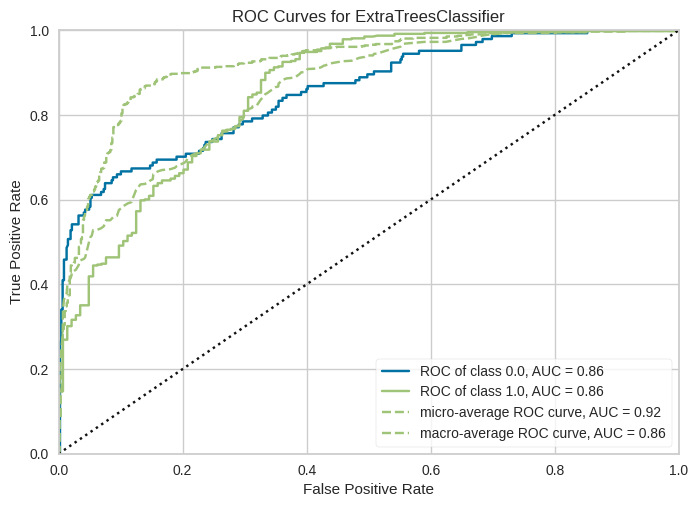

In [22]:
plot_model(tuned_model, plot = 'auc')

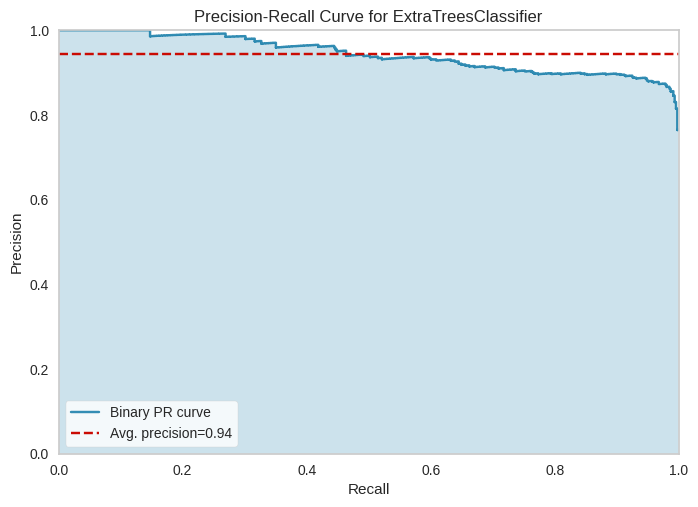

In [23]:
plot_model(tuned_model, plot = 'pr')

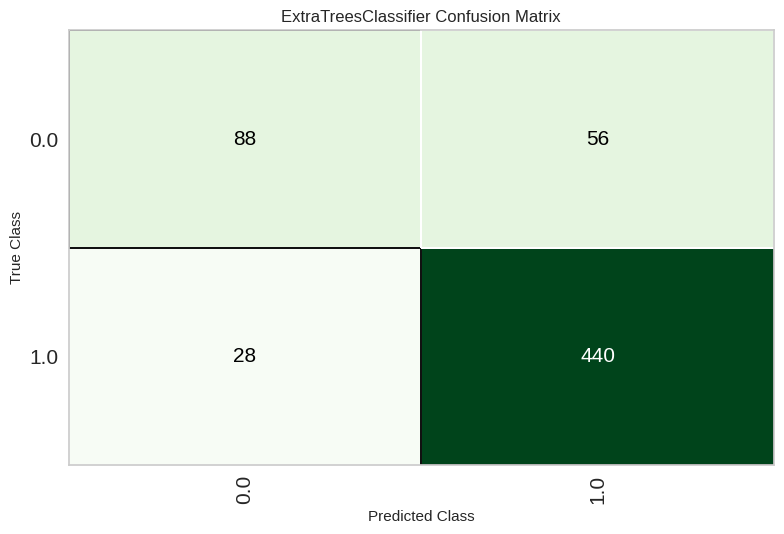

In [24]:
plot_model(tuned_model, plot = 'confusion_matrix')

In [25]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [30]:
#final_model = finalize_model(tuned_model)
#print(final_model)